In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from scipy.integrate import odeint

from covid_data_helper import *
from coronita_model_helper import *
%load_ext autoreload
%autoreload 2

In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

df_counties = get_complete_county_data()

counties_geo = get_counties_geo()

df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

df_interventions = get_state_policy_events()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

#######################

State Testing Data Last Observation:  20201021
Got COVID19 Tracking Data
Got Census Data
Got NYS DOH data
Got Census Data
Got NYT county level data.
Got Google Movement Data
Got Complete County Data
Got counties geo json
Got JHU county level data.
Got KFF Policy dates
Got Google Movement Data


In [3]:
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)
    

./output/allstate_model_dicts_20201021.pkl


In [4]:
# l_states_to_fore = df_census.state.unique()
l_states_to_fore = ['NY']

In [5]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
days_to_forecast = 150

#######################

### RUN MODEL ###
df_fore_allstates = pd.DataFrame()

try:
    list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    print('last forecast: ', latest_file)
    df_prevfore_allstates = pd.read_pickle(latest_file)
except:
    if 'df_fore_allstates' in globals().keys():
        if df_fore_allstates.shape[0] > 0:
            df_prevfore_allstates = df_fore_allstates.copy()

last forecast:  ./output/df_fore_allstates_20201021.pkl


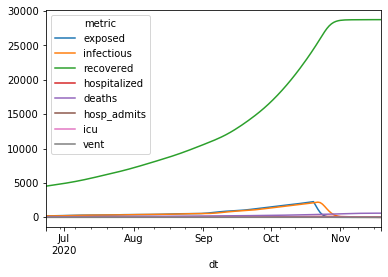

In [24]:
allstate_model_dicts['ND']['df_all_cohorts'
                          ].loc[:,:'2020-10-20'].sum(axis=1).unstack('metric').iloc[-270:-120].plot()


In [11]:
state= 'ND'

model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt,
                                   covid_params, days_to_forecast,
                                   df_mvmt=df_goog_mob_state
                                 , df_interventions=df_interventions
                                  )

this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[state])
this_reg_df_wavg = pd.DataFrame(
    model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[state])

# df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
# df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

try:
    first_guess = df_prevfore_allstates[state].first_valid_index()[0]
except:
    first_guess = pd.Timestamp('2020-02-17')

model_dict = model_find_start(first_guess, model_dict)
df_agg = model_dict['df_agg']
df_all_cohorts = model_dict['df_all_cohorts']

print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'

This guess:  2020-03-27 00:00:00
This error:  53.38262029942221
Change in error:  -1
Best starting date:  2020-03-27 00:00:00
Peak Hospitalization Date:  22 Dec, 2020
Peak Hospitalization #: 541
Peak ICU #: 172
Peak Ventilator #: 69


In [12]:
def ode_model(z, t, beta, sigma, gamma, mu):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    S, E, I, R, D = z
    N = S + E + I + R + D
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def ode_solver(t, initial_conditions, covid_params):
    initE, initI, initR, initN, initD = initial_conditions
    beta, sigma, gamma, mu = params['beta'].value, params['sigma'].value, params['gamma'].value, params['mu'].value
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initS, initE, initI, initR, initD], t, args=(beta, sigma, gamma, mu))
    return res


In [ ]:
def ode_model(z, t, covid_params):
    E, I_mild, I_sev, H, R, D = z
    dEdt = - sigma*E
    
    dI_milddt = sigma*E*(1-covid_params['hosp_rt']) - I_mild/covid_params['d_infect']
    
    dI_sevdt = sigma*E * covid_params['hosp_rt'] - I_sev/covid_params['d_to_hosp']
    
    ratio_H2R = (covid_params['hosp_rt'] - covid_params['mort_rt'])/covid_params['hosp_rt']
    ratio_H2D = 1-ratio_H2R
    dHdt = (I_sev/covid_params['d_to_hosp']
            - H*ratio_H2R*covid_params['d_in_hosp_mild'] 
            - H*ratio_H2D*(covid_params['d_til_death']-)
    dDdt = mu*H
    
    dRdt = gamma*I_mild
    return [dEdt, dIdt, dRdt, dDdt]

def ode_solver(t, initial_conditions, covid_params):
    initE, initI, initR, initN, initD = initial_conditions
    sigma = 1.0 / covid_params['d_incub']
    nu = 1.0 / covid_params['d_in_hosp_mild']
    gamma = 1.0 / covid_params['d_infect']
    mu = 1.0 / (covid_params['mort_rt'] / covid_params['hosp_rt'])
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initE, initI, initR, initD], t, args=covid_params)
    return res


In [16]:
def ode_model(z, t_, covid_params):
    E, I_mild, I_sev, H, R, D = z
    prob_dI_t = gamma.pdf(t_, covid_params['d_incub'])
    prob_dI_t = prob_dI_t / norm_fact_p_dI

    prob_mild_dR_t = (1 - covid_params['hosp_rt']) * gamma.pdf(t_, covid_params['d_infect'] + covid_params['d_incub'])
    prob_mild_dR_t = prob_mild_dR_t / norm_fact_p_dmR

    prob_H_inflow_fromE0_t = covid_params['hosp_rt'] * gamma.pdf(t_, covid_params['d_to_hosp'] + covid_params['d_incub'])
    prob_H_inflow_fromI0_t = covid_params['hosp_rt'] * gamma.pdf(t_, covid_params['d_to_hosp'] / 2, scale=2)

    prob_sev_dR_t = ( (covid_params['hosp_rt'] - covid_params['mort_rt'])
                      * gamma.pdf(t_, (covid_params['d_incub'] + covid_params['d_in_hosp'] + covid_params['d_to_hosp']) / 4, scale=4) )

    prob_dD_t = covid_params['mort_rt'] * gamma.pdf(t_, (covid_params['d_til_death'] + covid_params['d_incub']) / 1, scale=1)
    #############################################

    ############## FLOW ACCOUNTING ##############
    # Change in Exposed Population
    dEdt = -1 * min(prob_dI_t * E[0], E[-1])

    # Hospital Outflows, limited to be no more than hospital capacity
    d_hosp_outflow = -1 * min((prob_sev_dR_t * (E[0] + I[0])
                               + H[0] * (prob_sev_dR_t / (covid_params['hosp_rt'] - covid_params['mort_rt'])) * (1 - covid_params['mort_rt'] / covid_params['hosp_rt']))
                              + (prob_dD_t * (E[0] + I[0])
                                 + H[0] * (prob_dD_t / covid_params['mort_rt']) * covid_params['mort_rt'] / covid_params['hosp_rt']),
                              H[-1])

    if (prob_sev_dR_t + prob_dD_t) > 0:
        # Severe Recoveries - Component of Hospital Outflows
        d_sevR = (-1 * prob_sev_dR_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)

        # Deaths - Component of Hospital Outflows
        dDdt = (-1 * prob_dD_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)
    else:
        # Severe Recoveries - Component of Hospital Outflows
        d_sevR = 0.
        # Deaths - Component of Hospital Outflows
        dDdt = 0.

    # New Hospital Admittances
    d_hosp_admits = prob_H_inflow_fromE0_t * E[0] + prob_H_inflow_fromI0_t * I[0]

    # Infectious Inflows
    dI_inflow = -1 * dEdt

    # Mild Recoveries
    d_mildR = min(prob_mild_dR_t * (E[0] + I[0]), I[-1] + dI_inflow - d_hosp_admits)

    # Change in Recovered Population
    dRdt = d_mildR + d_sevR

    # Change in Hospitalized Population
    dHdt = d_hosp_admits + d_hosp_outflow

    # Infectious Outflows
    dI_outflow = d_mildR + d_hosp_admits

    # Net change in Infectious Population
    dIdt = dI_inflow - dI_outflow
    return [dEdt, dIdt, dHdt, dRdt, dDdt]

def ode_solver(t, initial_conditions, covid_params):
    initE, initI, initH, initR, initD = initial_conditions
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initE, initI, initR, initD], t, args=covid_params)
    return res

In [14]:
days = 365
initN = 1380000000
initE = 1
initI = 1
initR = 0
initD = 0
initial_conditions = [initE, initI, initR, initN, initD]

tspan = np.arange(0, days, 1)
sol = ode_solver(tspan, initial_conditions, covid_params)
S, E, I, R, D = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]

NameError: name 'params' is not defined

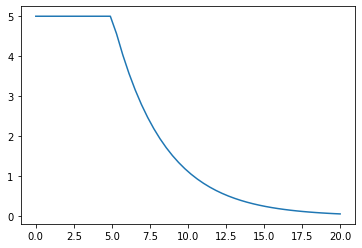

In [26]:
import matplotlib.pyplot as plt
# function that returns dy/dt
def model(y,t):
    if t >5:
        k = 0.3
        dydt = -k * y
    else:
        dydt = 0
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20)

# solve ODE
y = odeint(model,y0,t)

plt.plot(t,y)

array([[4.42375528],
       [3.91392204],
       [3.46284668],
       [3.06375722],
       [2.7106624 ],
       [2.3982614 ],
       [2.12186437],
       [1.87732164],
       [1.6609623 ],
       [1.46953813],
       [1.30017539],
       [1.15033154],
       [1.01775702],
       [0.90046157],
       [0.79668431],
       [0.70486726],
       [0.62363203],
       [0.55175909],
       [0.48816942],
       [0.4319084 ],
       [0.3821314 ],
       [0.33809115],
       [0.29912649],
       [0.26465247],
       [0.23415155],
       [0.20716582],
       [0.18329018],
       [0.16216617],
       [0.14347669],
       [0.12694116],
       [0.11231132],
       [0.09936756],
       [0.08791555],
       [0.07778338],
       [0.06881893],
       [0.06088762],
       [0.05387038],
       [0.04766188],
       [0.0421689 ],
       [0.03730898],
       [0.03300916],
       [0.02920489],
       [0.02583905],
       [0.02286113],
       [0.02022641],
       [0.01789534],
       [0.01583292],
       [0.014

In [19]:
allstate_model_dicts = {}
df_rts_allregs = pd.DataFrame()
df_wavg_rt_conf_allregs = pd.DataFrame()

for state in l_states_to_fore:
    print(state)
    
    model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
    
    this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[state])
    this_reg_df_wavg = pd.DataFrame(
        model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[state])

    df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
    df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

    try:
        first_guess = df_prevfore_allstates[state].first_valid_index()[0]
    except:
        first_guess = pd.Timestamp('2020-02-17')

    model_dict = model_find_start(first_guess, model_dict)
    df_agg = model_dict['df_agg']
    df_all_cohorts = model_dict['df_all_cohorts']

    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

    model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'

    allstate_model_dicts[state] = model_dict
    df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_agg.stack(), columns=[state])], axis=1)

#######################

### Add US Country Level Entries Before Saving ###
df_fore_us = df_fore_allstates.sum(axis=1, skipna=True).unstack('metric').dropna(how='all')
tot_pop = df_fore_us[['susceptible', 'deaths', 'exposed', 'hospitalized', 'infectious', 'recovered']].sum(axis=1)
max_tot_pop = tot_pop.max()
df_fore_us.loc[tot_pop<max_tot_pop, 'susceptible'] = df_fore_us['susceptible'] + (max_tot_pop - tot_pop)
df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_fore_us.stack(), columns=['US'])], axis=1)

model_dict = make_model_dict_us(df_census, df_st_testing_fmt, covid_params, d_to_forecast = 75,
                               df_mvmt=df_goog_mob_us, df_interventions=df_interventions)
model_dict['df_agg'] = df_fore_us
model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'
allstate_model_dicts['US'] = model_dict

this_reg_df_wavg = pd.DataFrame(
    model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=['US'])
df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)
###################################################

### Save Output ###
# df_rts_allregs.index.names = ['dt','metric']

# df_wavg_rt_conf_allregs.unstack('metric').to_csv(
#     './output/df_wavg_rt_conf_allregs_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_wavg_rt_conf_allregs.to_pickle('./output/df_wavg_rt_conf_allregs_{}.pkl'.format(
#     pd.Timestamp.today().strftime("%Y%m%d")))

# df_fore_allstates.unstack('metric').to_csv(
#     './output/df_fore_allstates_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_fore_allstates.unstack('metric').to_csv(
#     '../COVIDoutlook/download/df_fore_allstates_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_fore_allstates.to_pickle('./output/df_fore_allstates_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d")))

# asmd_filename = './output/allstate_model_dicts_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d"))

# df_interventions.to_csv('../COVIDoutlook/download/df_interventions.csv', encoding='utf-8')

# with open(asmd_filename, 'wb') as handle:
#     pickle.dump(allstate_model_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# os.system('say -v "Victoria" "Your forecasts are ready."')

######################

# os.system('python web_gen_covidoutlook.py &') # 'python web_gen_covidoutlook.py 2>&1 | tee -a web_gen_covidoutlook.log &'
# os.system('python web_gen_personal.py &')

NY
2020-10-01 00:00:00
hey
Best starting date:  2020-02-02 00:00:00
Peak Hospitalization Date:  15 Apr, 2020
Peak Hospitalization #: 19665
Peak ICU #: 6235
Peak Ventilator #: 2494
2020-10-01 00:00:00


2020-10-01 00:00:00


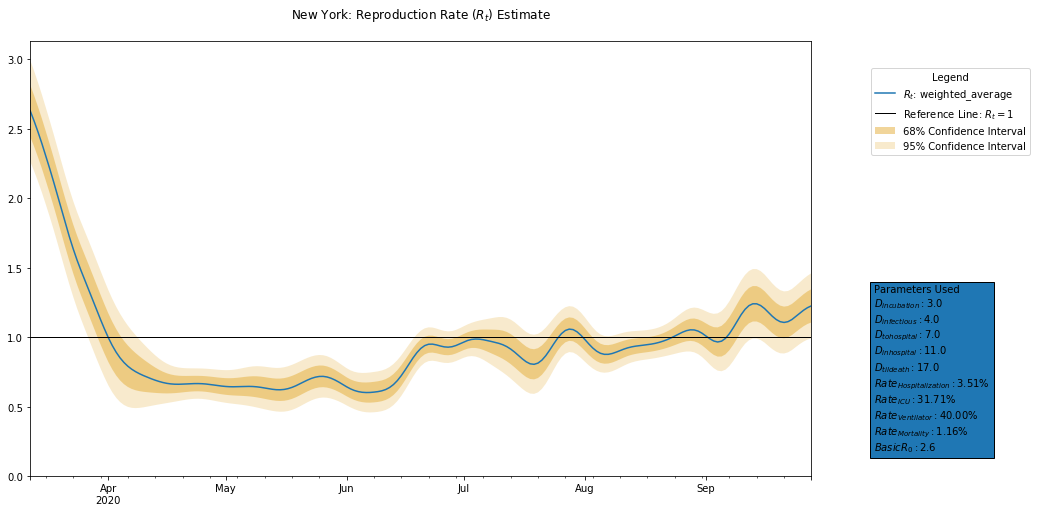

In [5]:
model_dict = make_model_dict_state('NY',abbrev_us_state,df_census,
    df_st_testing_fmt,
    covid_params,
    d_to_forecast=75,
    df_mvmt=df_goog_mob_state)
ax = ch_rt_confid(model_dict)

In [6]:
from coronita_chart_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

### Settings and Functions for Personal Website ###
plt.style.use('ggplot')

def footnote_str_maker():
    footnote_str = 'www.COVIDoutlook.info | twtr: @COVIDoutlook\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str


def add_plotly_footnote(fig):
    fig.update_layout(
                  annotations=[
                      dict(x = 0, y = -0.06,
                           xref='paper', yref='paper', font_size=10, showarrow=False,
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                            text='<a href="http://{0}">{0}</a> | twtr: <a href="https://twitter.com/COVIDoutlook">@COVIDoutlook</a> | '.format(
                           'www.COVIDoutlook.info')
                          ),
                      dict(x = 0, y = -0.09,
                           xref='paper', yref='paper', font_size=10, showarrow=False,
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
                          )
                  ]
                 )
    return fig
d_chart_fns = {'ch_rt_confid': ch_rt_confid,
 'ch_positivetests': ch_positivetests,
 'ch_totaltests': ch_totaltests,
 'ch_postestshare': ch_postestshare,
 'ch_detection_rt': ch_detection_rt,
 'ch_googmvmt': ch_googmvmt,
 'ch_exposed_infectious': ch_exposed_infectious,
 'ch_hosp': ch_hosp,
 'ch_population_share': ch_population_share,
 'ch_cumul_infections': ch_cumul_infections,
 'ch_daily_exposures': ch_daily_exposures,
 'ch_hosp_admits': ch_hosp_admits,
 'ch_daily_deaths': ch_daily_deaths}


NY


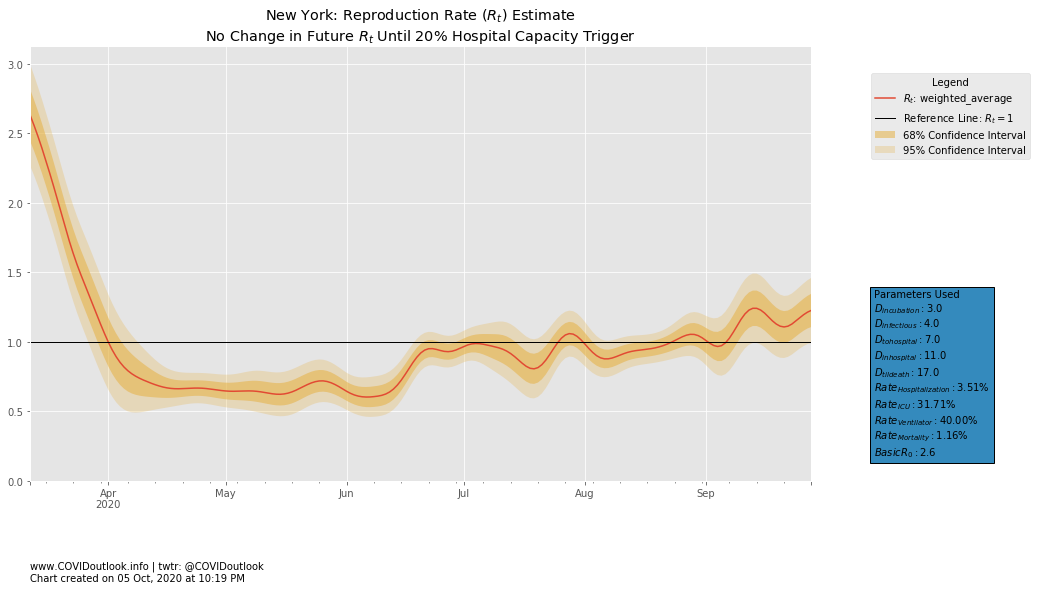

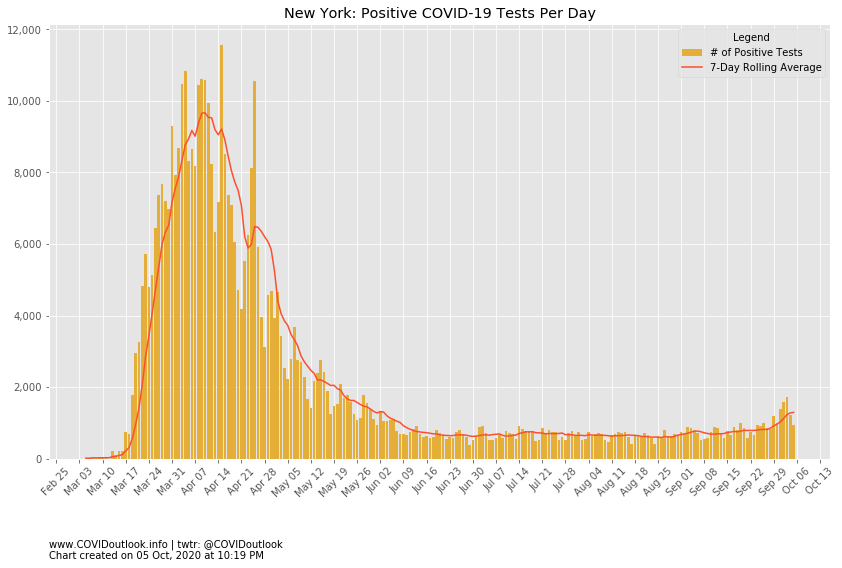

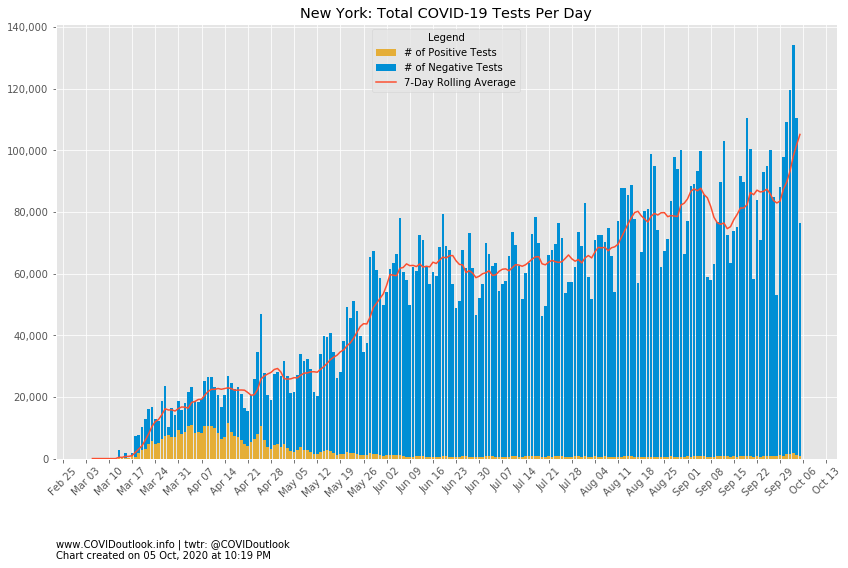

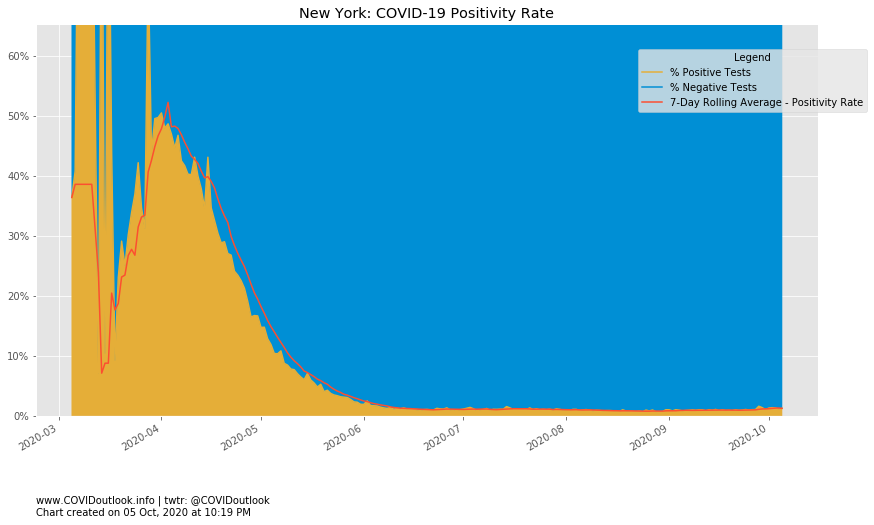

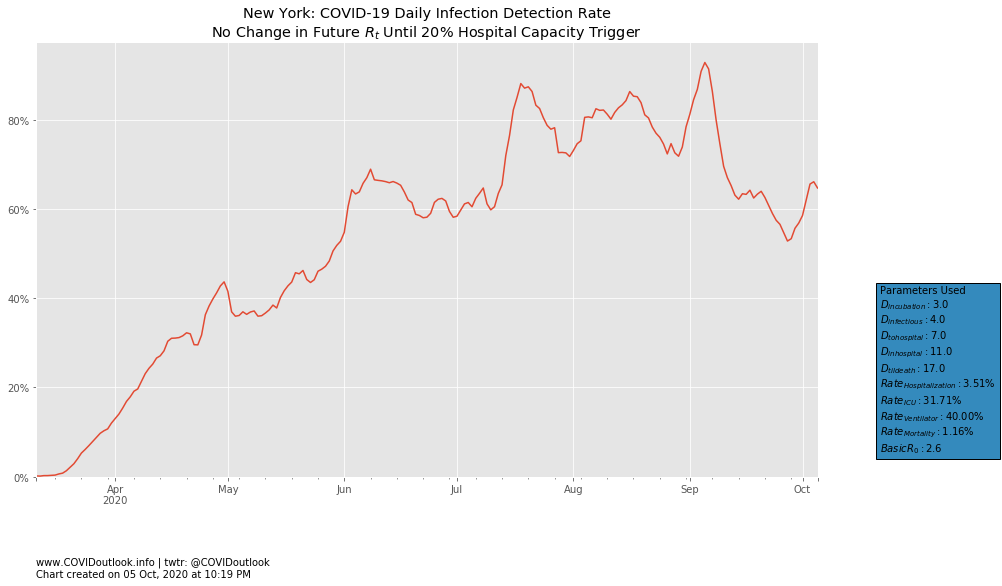

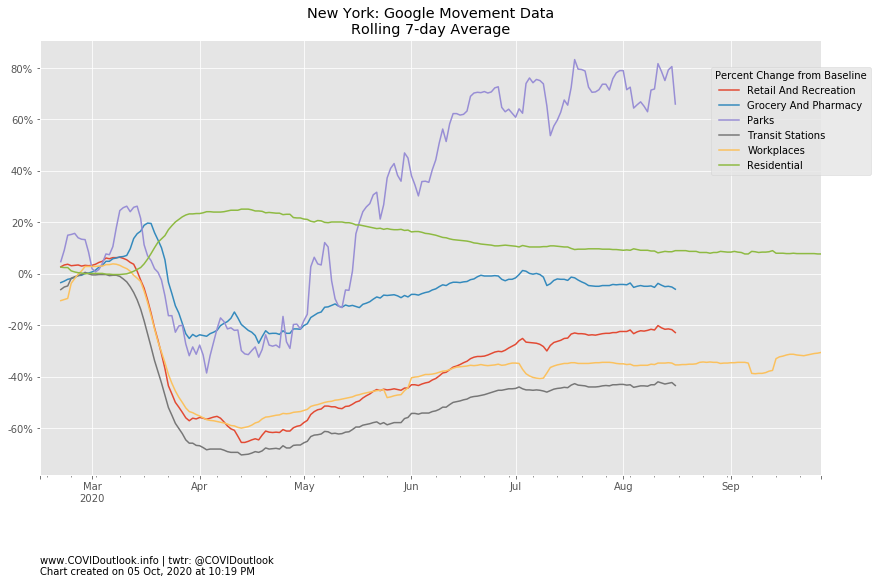

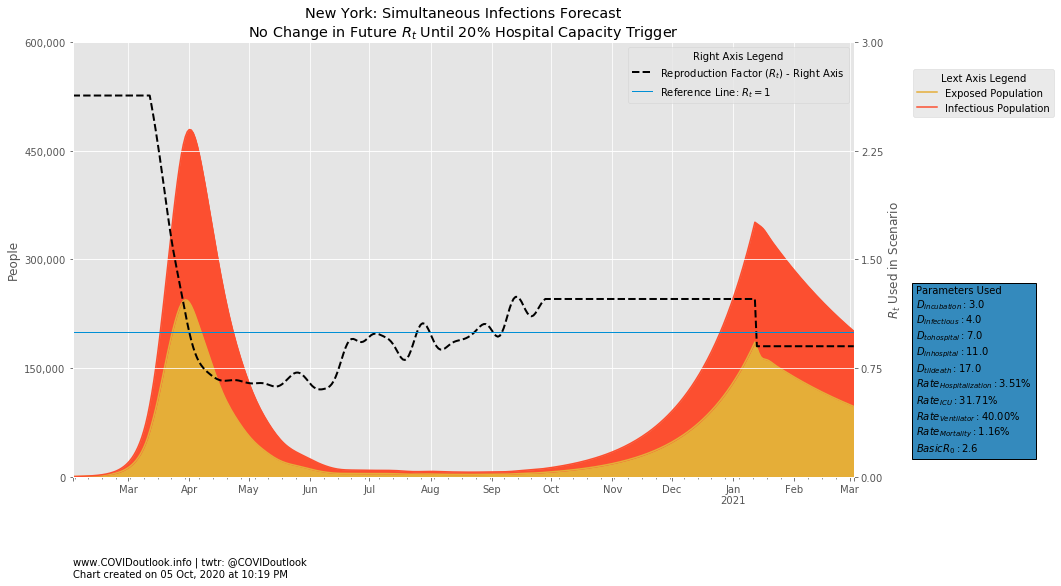

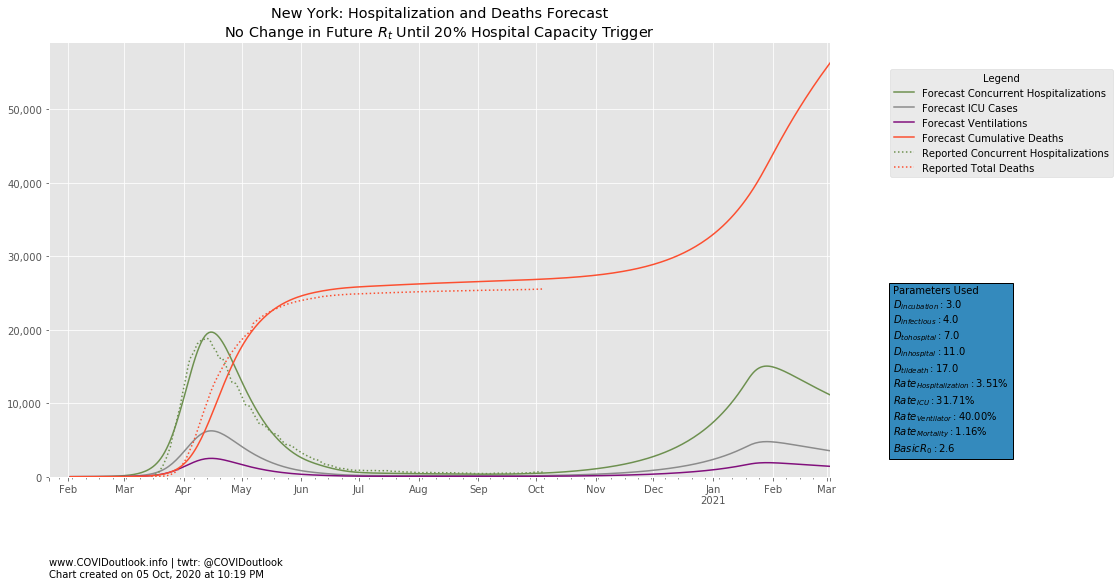

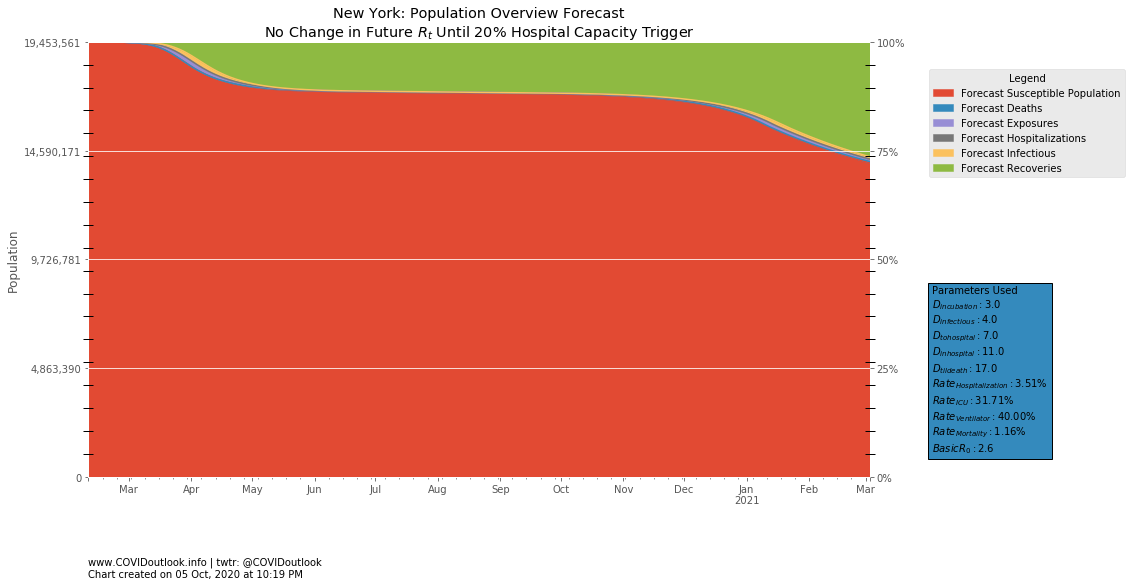

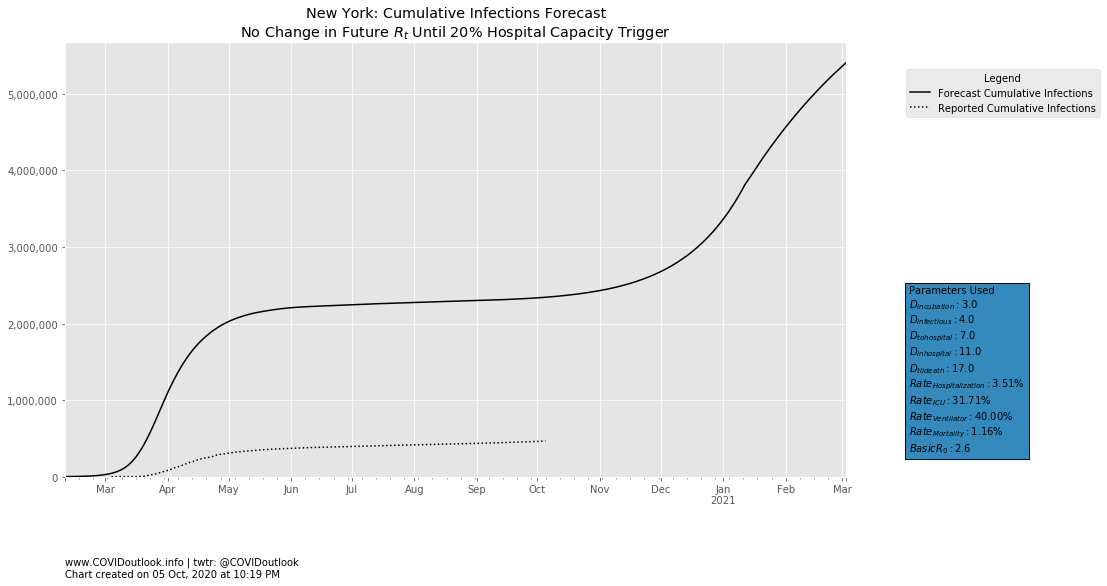

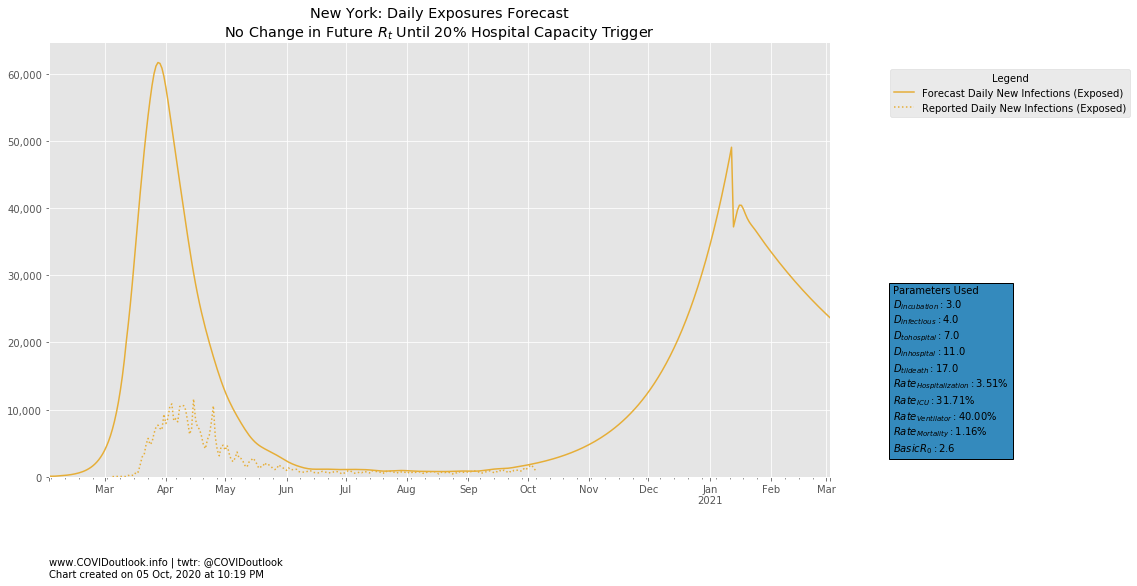

Couldn't create NY ch_hosp_admits chart.
Couldn't create NY ch_daily_deaths chart.


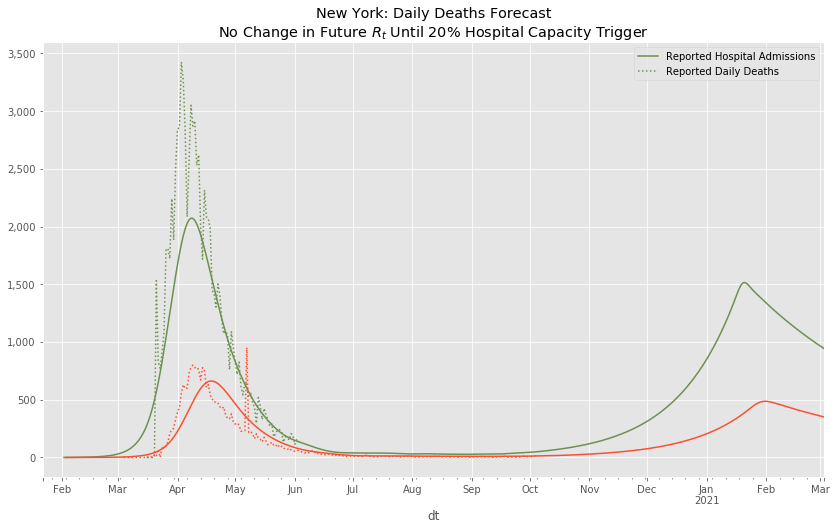

In [7]:
for state_code in l_states_to_fore:
    print(state_code)
    model_dict = allstate_model_dicts[state_code]
    model_dict['footnote_str'] = footnote_str_maker()

    # fig = ch_statemap2(df_counties.query('dt == dt.max() and state == "{}"'.format(state_code)),
    #                    model_dict['region_name'],
    #                    df_counties.query('dt == dt.max()').cases_per100k.quantile(.9),
    #                    counties_geo
    #                   )
    fig = ch_statemap_casechange(model_dict, df_counties, counties_geo)
    fig = add_plotly_footnote(fig)
    # fig.write_html('../COVIDoutlook/forecasts/plotly/{}_casepercap_cnty_map.html'.format(
    #     model_dict['region_code']), include_plotlyjs='cdn')

    for ch_name, ch_fn in d_chart_fns.items():
        try:
            ax = ch_fn(model_dict)
            filename = '../COVIDoutlook/assets/images/covid19/{}_{}.png'.format(
                model_dict['region_code'], ch_name)
    #         plt.savefig(filename, bbox_inches='tight')
            plt.show()
            plt.close()
            # os.system('optipng {} &'.format(filename))
        except:
            print('Couldn\'t create {} {} chart.'.format(model_dict['region_code'], ch_name))

    statetab_output_cols = ['Riskiest State Rank', 'Population',
                   'Model Est\'d Active Infections', 'Current Reproduction Rate (Rt)',
                   'Total Cases', '14-Day Avg Daily Cases',
                   'Positivity Rate',
                   'Total Deaths', '14-Day Avg Daily Deaths',
                   'Hospitalized', '14-Day Avg Daily Hosp Admits'
                   ]
    # if state_code == 'US':
    #     statetab = df_tab_us[statetab_output_cols[1:]].replace('nan', 'Not Available')
    # else:
    #     statetab = df_tab.loc[df_tab.state==state_code, statetab_output_cols].replace('nan', 'Not Available')

    # statetab_html = statetab.to_html(index=False, border=0, justify='center', escape=False)
    # statetab_html = statetab_html.replace(
    #     'class="dataframe"', 'class="w3-table w3-striped w3-bordered w3-hoverable w3-medium"')
    # statetab_html = statetab_html.replace(
    #     '<tr style="text-align: center;">', '<tr style="text-align: center;" class="w3-light-grey">')

    # l_content = [statetab_html, '### How Fast is COVID-19 Currently Spreading?']

    # for thischart in l_charts:
    #     if thischart == 'ch_statemap':
    #         # l_content.append('{{% include_relative plotly/{}_casepercap_cnty_map.html %}}'.format(state_code))
    #         l_content.append(state_plotly_html.format(state_code))
    #     else:
    #         l_content.append("<img src='/assets/images/covid19/{}_{}.png'>".format(
    #             state_code, thischart))

    #     if thischart in dict_ch_defs.keys():
    #         l_content.append(dict_ch_defs[thischart]+'\n- - - -')

    # l_content.insert(15, '### Model and Forecast Results')

    # final_md = state_md_template.format(model_dict['region_name'], state_code, '\n'.join(l_content))

    # if state_code == 'US':
    #     filename = "../COVIDoutlook/forecasts/index.md".format(state_code)
    # else:
    #     filename = "../COVIDoutlook/forecasts/{}.md".format(state_code)

    # with open(filename, "w") as file:
    #     file.write(final_md)